# Éléments de symétrie du Na2Te.
#### Vaessen Louise, 59762100.

### Importation des packages et des données nécessaires. 

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from matplotlib import pyplot as plt
from scipy import integrate as intg

In [2]:
mp_key = "iHKrsQ8aWfQ1QaXnodlQAIOBI4QNOfIj"
mp_id = "mp-2784"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Calcul des températures de d'Einstein et de Debye sur base d'une approximation aux moindres carrés.

La chaleur spécifique a été modélisée selon deux modèles, celui d'Einstein et de Debye. Les deux modèles sont des approximations et ne tiennent pas compte des relations de dispersions générales. 

Einstein a supposé que chaque atome du cristal vibre autour de sa position d'équilibre à une fréquence caractéristique, indépendamment des autres atomes. Il néglige donc l'interaction entre atomes. L'ensemble des atomes du cristal vibrent à la même fréquence $\omega_{E}$. On peut lier cette fréquence à une température via : $k_{B}\Theta_{E} = ħ\omega_{E}$, avec $k_{B}$ la constante de Boltzmann (en $\frac{J}{K}$), $\Theta_{E}$ la température d'Einstein (en K), $ħ$ la constante de Planck (en Js) et $\omega_{E}$ la fréquence d'Einstein (en $\frac{rad}{s}$). Pour ce modèle, l'expression de la chaleur spécifique devient : $\frac{C_v}{3N_{at}R} = (\frac{\Theta_E}{T})^2\frac{e^{\frac{\Theta_E}{T}}}{(e^{\frac{\Theta_E}{T}} - 1)^2}$.

Debye a effectué l'hypothèse que les fréquences propres ont la même dispersion linéaire : $\omega_{\sigma}(q) = vq$ avec $v$ la vitesse de phase et $q$ le vecteur d'onde. La fréquence maximale admissible $\omega_D$est donc liée à un vecteur d'onde maximal $q_D$. À nouveau, on peut lier cette fréquence à une température : $k_{B}\Theta_{D} = ħ\omega_{D}$, $\Theta_{D}$ la température de Debye (en K) et $\omega_{D}$ la fréquence de Debye (en $\frac{rad}{s}$). La température de Debye représente la température à partir de laquelle tous les modes de vibrations sont excités. La chaleur spécifique est exprimée comme : $\frac{C_v}{3N_{at}R} = 3(\frac{\Theta_D}{T})^3\int_{0}^{\frac{\Theta_D}{T}}{\frac{x^4e^x}{(e^x - 1)^2}}dx$.


De point de vue de la chaleur spécifique, la différence des deux modèles se situe aux basses températures. Pour le modèle d'Einstein, lorsque la température est inférieure à la température d'Einstein, la chaleur spécifique est proportionnelle à $e^{\frac{-\Theta_E}{T}}$. Celle issue du modèle de Debye varie en $T^3$, ce qui est plus proche des résultats expérimentaux. 

Le modèle de Debye devrait mieux coller aux résultats expérimentaux que celui d'Einstein car l'approximation d'Einstein s'éloigne plus de la réalité. 

Ci dessous, nous pouvons trouver un graphe montrant les chaleurs spécifiques en fonction des températures pour les différents modèles sur base des températures d'Einstein et de Debye calculées via une approximation aux moindres carrés. 

In [4]:
# Creation des variables necessaires.

temperatures = np.arange(0,1000,5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)
frequency = ph_dos.frequencies
density = ph_dos.densities

In [5]:
# Calcul des temperatures d'Einstein et de Debye.

min_squared_error_E_global = 0
min_squared_error_D_global = 0
Cv_T_E_optimisee = []
Cv_T_D_optimisee = []

T_range = np.arange(1, 1000, 1)
T_E_optimisee = 0
T_D_optimisee = 0

def Cv_Einstein(T, T_E):
    """
    Retourne Cv/3N*R pour le modèle d'Einstein.
    """
    return (T_E / T) ** 2 * np.exp(T_E / T) / (np.exp(T_E / T) - 1) ** 2

def integrande(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1) ** 2

def Cv_Debye(T, T_D):
    """
    Retourne Cv/3N*R pour le modèle de Debye.
    """

    integrale = float(intg.romberg(integrande, 0.000000000000001, T_D/T))
    return 3*(T/T_D)**3 * integrale

for i in range(len(T_range)) : 
    min_squared_error_E = 0
    min_squared_error_D = 0

    T_E = float(T_range[i])
    T_D = float(T_range[i])
    for j in range(1, len(temperatures)):
        cv_E = Cv_Einstein(float(temperatures[j]), T_E)
        cv_D = Cv_Debye(float(temperatures[j]), T_D)
        min_squared_error_E += (float(ph_cv[j]) - cv_E) ** 2 
        min_squared_error_D += (float(ph_cv[j]) - cv_D) ** 2
    

    
    if i == 0:
        min_squared_error_E_global = min_squared_error_E
        min_squared_error_D_global = min_squared_error_D
        T_E_optimisee = T_E
        T_D_optimisee = T_D
    

    elif min_squared_error_E <= min_squared_error_E_global :
        min_squared_error_E_global = min_squared_error_E
        T_E_optimisee = T_E
    
    elif min_squared_error_D <= min_squared_error_D_global :
        min_squared_error_D_global = min_squared_error_D
        T_D_optimisee = T_D 
    
print("Température de Debye = " + str(T_D_optimisee) + "K")
print("Température d'Einstein = " +  str(T_E_optimisee) + "K")

for i in range(len(temperatures)) :
    if i == 0 :
        Cv_T_E_optimisee.append(0)
        Cv_T_D_optimisee.append(0)
    else :
        Cv_T_E_optimisee.append(Cv_Einstein(float(temperatures[i]), T_E_optimisee))
        Cv_T_D_optimisee.append(Cv_Debye(float(temperatures[i]), T_D_optimisee))


Température de Debye = 223.0K
Température d'Einstein = 165.0K


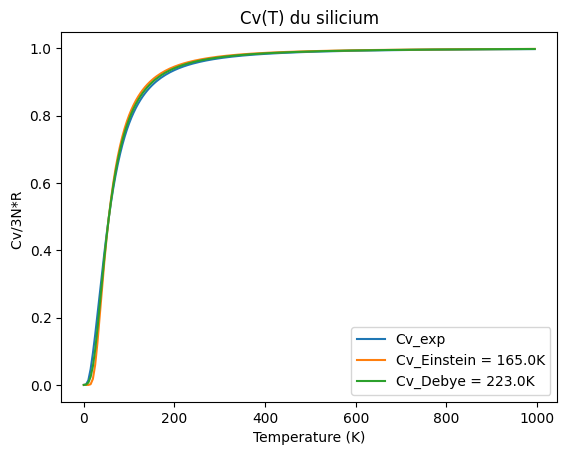

In [6]:
# Affichage des résultats.

for i in range(len(temperatures)) :
    temperatures[i] = float(temperatures[i])
    ph_cv[i] = float(ph_cv[i])


plt.plot(temperatures, ph_cv, label='Cv_exp')
plt.plot(temperatures, Cv_T_E_optimisee, label='Cv_Einstein = ' + str(T_E_optimisee) + 'K')
plt.plot(temperatures, Cv_T_D_optimisee, label='Cv_Debye = ' + str(T_D_optimisee) + 'K')
plt.xlabel('Temperature (K)')
plt.ylabel('Cv/3N*R ')
plt.title('Cv(T) du silicium')
plt.legend()
plt.show()

Comme nous pouvons le voir sur la figure, aux basses températures, le modèle de Debye est plus proche des résultats expérimentaux. 

## Densités d'états de phonons correspondants

La densité d'état de phonon représente les différents modes de vibrations accessibles pour une fréquence donnée pour les phonons. La densité d'état totale pour un matériau (l'aire sous la courbe) vaut $3N_{at}$ (avec $N_{at}$ qui est le nombre d'atome dans la cellule unité). En effet, chaque atome peut vibrer selon 3 directions. Les modèles d'Einstein et de Debye doivent respecter cette condition.

Pour le modèle d'Einstein, une seule fréquence est considérée. Donc, les états disponibles sont tous situés à la même fréquence. Etant donné que la densité de mode doit être égale à $3N_{at}$, la DOS pour le modèle d'Einstein consiste en un delta de Dirac en $\omega = \omega_{E}$, dont la hauteur vaut $3N_{at}$.

Pour le modèle de Debye, chaque fréquence propre de vibration ont la même dispersion linéaire. On a donc que : $\omega_{\sigma}(q) = vq$ avec $v$ la vitesse de phase et $q$ le vecteur d'onde. Dans ce cas, la densité des modes normaux est décrite par une fonction parabolique d'équation : $\frac{3N_{at}\Omega\omega^2}{2\pi^2v^3}$ (avec $N_{at}$ le nombre d'atomes de la cellule unité, $\Omega$ le volume de la maille primitive (en m), $v$ la vitesse de phase et $\omega$ la fréquence considérée (en [$\frac{rad}{s}$]) ) si la fréquence est plus petite que la fréquence de Debye, et vaut 0 au delà de la fréquence de Debye. La vitesse de phase en calculée via $v = \frac{\omega_{D}}{q_{D}}$, avec $q_{D} = (\frac{6\pi^2}{\Omega})^\frac{1}{3}$ en [$\frac{1}{m}$]. La fréquence de Debye est celle qui garantit que l'aire sous la courbe de Debye soit égale à celle de la courbe exacte. 

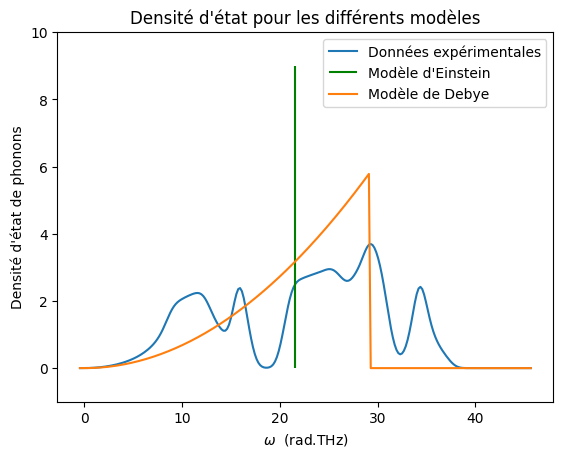

In [45]:
h_barre = 6.626*10**(-34)/(2*np.pi) # En J.s
k_B = 1.380649*10**(-23) # En J/K



# Pour Einstein : delta de dirac en w_ein.
w_ein = 10**(-12)*k_B*T_E_optimisee/(h_barre) # En THz*rad
g_E = 3*nat # Aire sous la courbe
f_einst = w_ein/(2*np.pi) # En THz



# Pour Debye : 
w_debye = 10**(-12)*k_B*T_D_optimisee/(h_barre) # En THz*rad
dos_debye = []
volume = 95.90*10**(-30) # En m

q_d = (6*np.pi*np.pi/volume)**(1/3) # En 1/m

for i in range(len(frequency)) : 
    w = frequency[i]*2*np.pi # Car frequency nous est donné en THz et non en rad*THz.
    if(w < w_debye) : 
        dos_debye.append(2*np.pi*3*nat*volume*w*w*q_d**3/(2*np.pi*np.pi*(w_debye)**3))
    else : 
        dos_debye.append(0)


# Plot.
plt.plot(frequency*2*np.pi, density, label = "Données expérimentales")
plt.vlines(f_einst*2*np.pi, 0, g_E, label = "Modèle d'Einstein", color = 'g')
plt.plot(frequency*2*np.pi, dos_debye, label = "Modèle de Debye")
plt.xlabel('$\omega$  (rad.THz)')
plt.ylabel("Densité d'état de phonons")
plt.ylim(-1, 10)
plt.title("Densité d'état pour les différents modèles")
plt.legend()
plt.show()

In [42]:
# Calcul des aires.
aire_ein = g_E
aire_exp = 0
aire_debye = 0
for i in range(len(frequency)-1) : 
    aire_exp += (density[i])*(frequency[i+1] - frequency[i])
    aire_debye += (dos_debye[i])*(frequency[i+1] - frequency[i])
print("Aire sous la courbe des données expérimentales : " + str(aire_exp))
print("Aire sous la courbe de Debye : " + str(aire_debye))
print("Aire sous la courbe d'Einstein : " + str(aire_ein))

Aire sous la courbe des données expérimentales :8.999991166056049
Aire sous la courbe de Debye :9.015891700869224
Aire sous la courbe d'Einstein :9


Nous pouvons voir que les différentes aires sont équivalentes et valent $3N_{at}$, ce qui correspond au nombre total de modes dans la cellule unité. 